In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas_datareader
!pip install yfinance

In [2]:
!nvidia-smi


Thu Nov 23 01:00:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
!pip install ipython-autotime
%load_ext autotime

time: 390 µs (started: 2023-11-23 01:00:14 +00:00)


In [32]:
#importing libraries
import math
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from keras.losses import Huber
plt.style.use('fivethirtyeight')

# Data Loading and Visualisation

In [33]:
def describe_dataset(dataset:pd.DataFrame):
    _data = dataset
    print("Dataset view (first 5 rows)")
    display(_data.head())
    print(f"Dataset dimensions: {_data.shape[0]} x {_data.shape[1]}\n")
    print("Dataset info\n")
    _data.info()
    print("\nDataset description\n")
    display(_data.describe(include='all'))
    print(f" Number of NaN entries: {sum(_data.isna().sum())}")
    print(f" Number of duplicated entries: {_data.duplicated().sum()}")
    return _data

In [34]:
df = pd.read_csv('MSFT_stock_data.csv')

describe_dataset(df)
# Let's assume 'Close' is your target column
# Calculate the rate of return
df['Return'] = df['Close'].pct_change()

Dataset view (first 5 rows)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.620001,31.100000,30.590000,30.950001,23.474918,38409100
1,2010-01-05,30.850000,31.100000,30.639999,30.959999,23.482504,49749600
2,2010-01-06,30.879999,31.080000,30.520000,30.770000,23.338398,58182400
3,2010-01-07,30.629999,30.700001,30.190001,30.450001,23.095675,50559700
4,2010-01-08,30.280001,30.879999,30.240000,30.660000,23.254961,51197400


Dataset dimensions: 3272 x 7

Dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3272 non-null   object 
 1   Open       3272 non-null   float64
 2   High       3272 non-null   float64
 3   Low        3272 non-null   float64
 4   Close      3272 non-null   float64
 5   Adj Close  3272 non-null   float64
 6   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 179.1+ KB

Dataset description



,Date,Open,High,Low,Close,Adj Close,Volume
count,3272,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
unique,3272,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,100.090715,101.082078,99.050037,100.115355,94.491769,3.801156e+07
std,NaN,88.247581,89.200539,87.220896,88.254726,88.491074,2.147184e+07
min,NaN,23.090000,23.320000,22.730000,23.010000,17.613327,7.425600e+06
25%,NaN,31.807499,32.032500,31.592500,31.815000,25.740532,2.384465e+07
50%,NaN,55.680000,56.049999,55.160000,55.740000,49.648857,3.227825e+07
75%,NaN,139.607498,140.390003,138.002499,139.070000,133.537075,4.679112e+07


 Number of NaN entries: 0
 Number of duplicated entries: 0


In [35]:
#converting dates to type datetime from object
def string_to_datetime(finance_date):
    year, month, day = finance_date.split('-')
    return datetime(year = int(year), month= int(month), day= int(day))

df["Date"] = df["Date"].apply(string_to_datetime)
#replacing index with Date so that RNN understands sequential nature of data
df.index = df.pop('Date')
df = df.loc[df['High']>df['Adj Close']]
# Drop the NaN values
df = df.dropna()


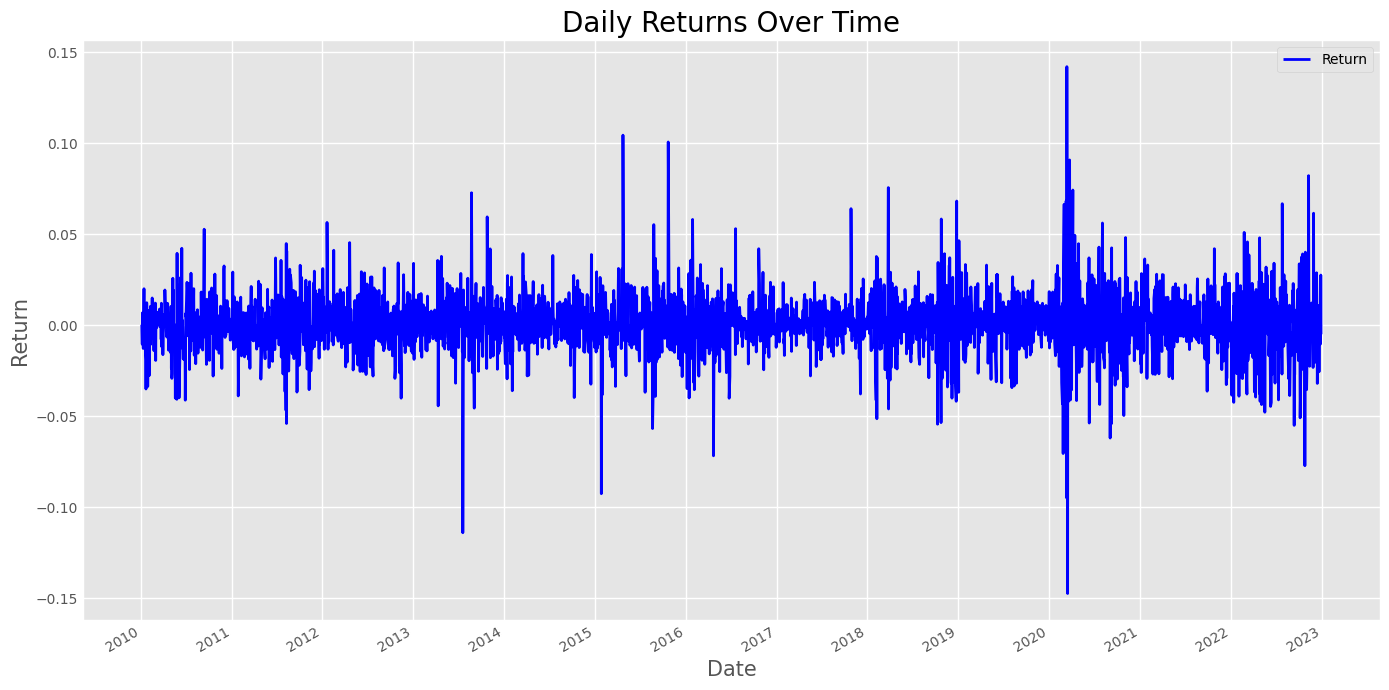

In [36]:
# Set the plot style for aesthetics
plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 7))  # Adjust the size to your preference

# Plot the 'Return' data
ax.plot(df.index, df['Return'], color='blue', linewidth=2, label='Return')

# Set the title and labels
ax.set_title('Daily Returns Over Time', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Return', fontsize=15)

# Format the date axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Get a tick for each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the tick to show the year
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Get a tick for each month

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Enable grid for better readability
ax.grid(True)

# Show the legend
ax.legend()

# Tight layout often produces a nicely laid-out plot
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Normalize the 'Return' column
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [38]:
feature = df['Open']
target = df['Return']

In [39]:
# Split the dataset into train and test sets
train_size = int(len(feature) * 0.8)
train_feature, test_feature = feature.iloc[:train_size].values.reshape(-1,1), feature.iloc[train_size:].values.reshape(-1,1)
train_target, test_target = target.iloc[:train_size].values.reshape(-1,1), target.iloc[train_size:].values.reshape(-1,1)

print(f"\n{train_feature.shape=}, {test_feature.shape=} \n{train_target.shape=}, {test_target.shape=}\n")


train_feature = scaler_X.fit_transform(train_feature)
test_feature = scaler_X.transform(test_feature)

train_target = scaler_y.fit_transform(train_target)
test_target = scaler_y.transform(test_target)


train_feature.shape=(2616, 1), test_feature.shape=(655, 1) 
train_target.shape=(2616, 1), test_target.shape=(655, 1)



In [40]:
# Convert an array of values into a dataset matrix
def create_sequences(Xsc,ysc, look_back):
    X,y =[],[]
    for i in range(Xsc.shape[0]-look_back):
        X.append(Xsc[i:i+look_back,:])

        y.append(ysc[i+look_back,:])

    return np.array(X),np.array(y)

In [41]:
# Reshape into sequences into sizes of 30
look_back = 30
X_train, y_train = create_sequences(train_feature, train_target, look_back)
X_test, y_test = create_sequences(test_feature, test_target, look_back)

print(f"\n{X_train.shape=}, {y_train.shape=} \n{X_test.shape=}, {y_test.shape=}\n")



X_train.shape=(2586, 30, 1), y_train.shape=(2586, 1) 
X_test.shape=(625, 30, 1), y_test.shape=(625, 1)



In [42]:
def plot_loss(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Training & Validation Loss')
    plt.legend(['training loss','validation loss',])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [43]:
def reconstruct_original_shape(X_sequences, original_shape):
    reconstructed_X = []
    for sequence in X_sequences:
        for i in range(sequence.shape[0]):
            reconstructed_X.append(sequence[i, :])

    return np.array(reconstructed_X)[:original_shape[0], :]

In [44]:
def plot_residual(y_test,predictions):
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    plt.figure(dpi=80, facecolor='w', edgecolor='k')
    residual = scaler_y.inverse_transform(y_test)-scaler_y.inverse_transform(predictions)
    _predicted = scaler_y.inverse_transform(predictions)
    axs[0].scatter(_predicted,residual, color='blue', marker='o',label='Fitted values')
    axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Residuals')
    axs[0].set_title('Residual plot')
    axs[1].hist(residual, linewidth=1,bins=20, edgecolor='black')
    axs[1].set_title('Histogram plot of residual')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [45]:
def train(model,X_train,y_train,X_test,y_test,epochs,batch_size,shuffle,validation_split):
    print(model.summary())
    _model = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,shuffle=shuffle,validation_split=validation_split)
    plot_loss(_model)
    predictions = model.predict(X_test)
    plot_residual(y_test,predictions)
    table = [[f'Training {model.loss} Loss',f'Validation {model.loss} Loss','Training RMSE'	,'Training MAE',	'Training MAPE','Validation RMSE'	,'Validation MAE',	'Validation MAPE'],
         [_model.history['loss'][-1],_model.history['val_loss'][-1] ,_model.history['root_mean_squared_error'][-1], _model.history['mean_absolute_error'][-1], _model.history['mean_absolute_percentage_error'][-1],_model.history['val_root_mean_squared_error'][-1] ,_model.history['val_mean_absolute_error'][-1] ,_model.history['val_mean_absolute_percentage_error'][-1] ]]
    print("\n",tabulate(table,headers='firstrow'),"\n\n")
    return _model, predictions#, predicted_prices

# RNN

## Mean Absolute Error (MAE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 30ms/step - loss: 0.1421 - root_mean_squared_error: 0.2289 - mean_absolute_error: 0.1421 - mean_absolute_percentage_error: 28.0191 - val_loss: 0.0638 - val_root_mean_squared_error: 0.0980 - val_mean_absolute_error: 0.0638 - val_mean_absolute_percentage_error: 1727506.5000
Epoch 2/25
73/73 [==============================] - 3s 39ms/step - loss: 0.0358

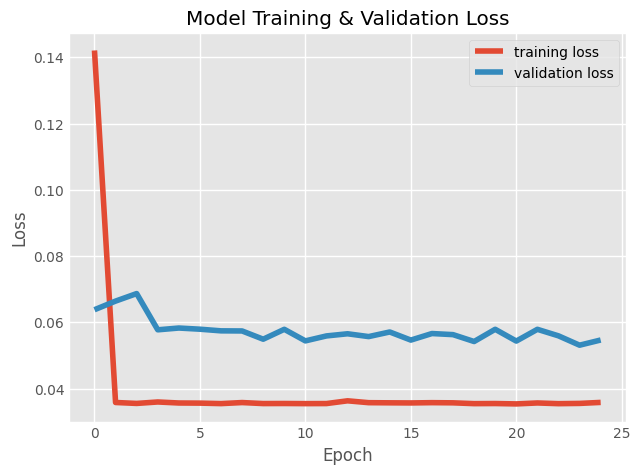

20/20 [==============================] - 0s 6ms/step


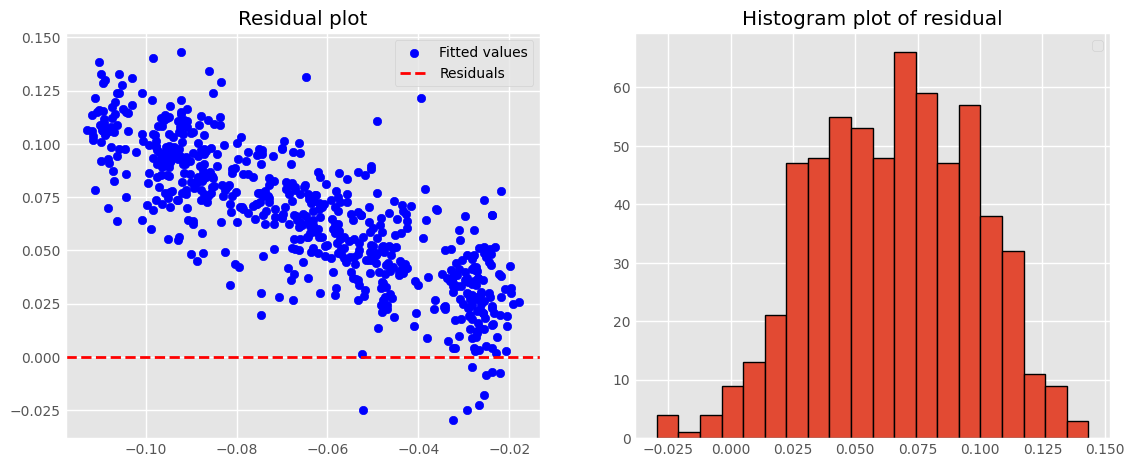

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0358149                              0.0546579        0.0508058       0.0358149          7.26826          0.0870514         0.0546579        1.96076e+06 




In [46]:
model_simple_rnn1 = Sequential()
model_simple_rnn1.add(SimpleRNN(10, activation='tanh',input_shape=(look_back, 1)))
model_simple_rnn1.add(Dense(1,activation='tanh'))

# Compile the model
model_simple_rnn1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])


# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn1_stats, rnn1_predictions= train(model=model_simple_rnn1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Mean Absolute Percentage Error

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 5s 38ms/step - loss: 12.8299 - root_mean_squared_error: 0.1121 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 12.8299 - val_loss: 1895326.1250 - val_root_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.0542 - val_mean_absolute_percentage_error: 1895326.1250
Epoch 2/25
73/73 [==============================] - 2s 22ms/step - loss: 7.5

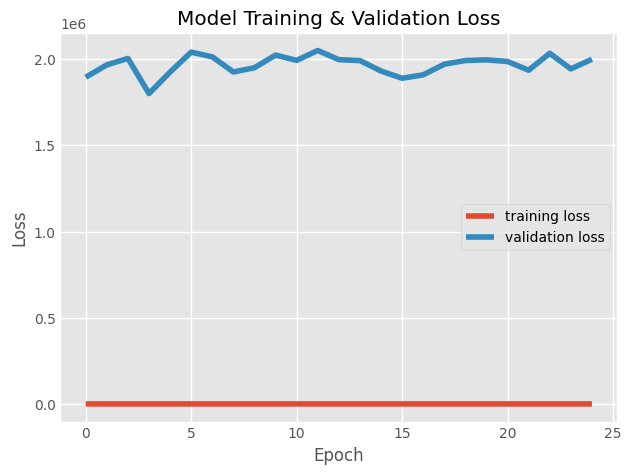

20/20 [==============================] - 0s 4ms/step


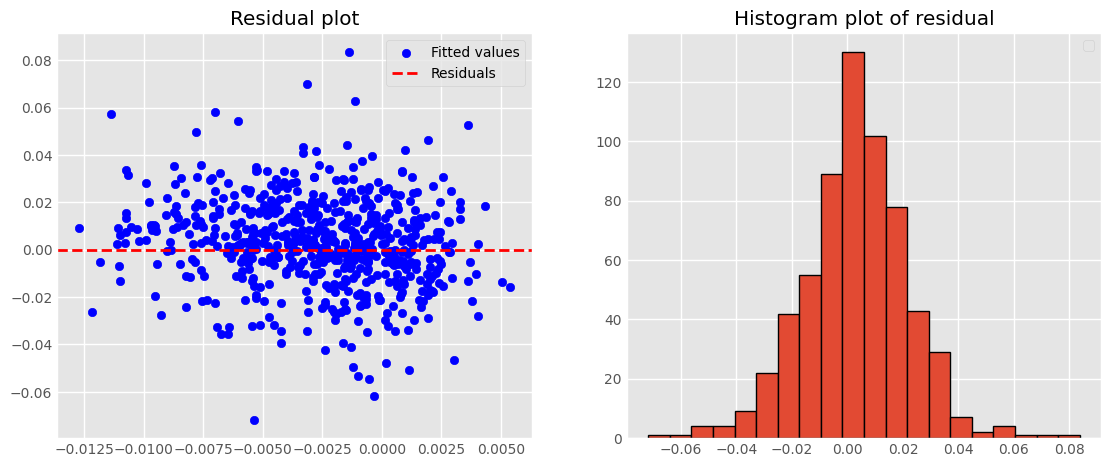

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.52312                                       1.99952e+06        0.0517884        0.037234          7.52312          0.0852217         0.0524265        1.99952e+06 




In [47]:
model_simple_rnn2 = Sequential()
model_simple_rnn2.add(SimpleRNN(50, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn2.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
# model_simple_rnn.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_split = 0.1)

rnn2_stats, rnn2_predictions= train(model=model_simple_rnn2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Huber

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 6s 40ms/step - loss: 0.0088 - root_mean_squared_error: 0.1326 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 14.9191 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0538 - val_mean_absolute_percentage_error: 1922055.6250
Epoch 2/25
73/73 [==============================] - 3s 38ms/step - loss: 0.0013 - r

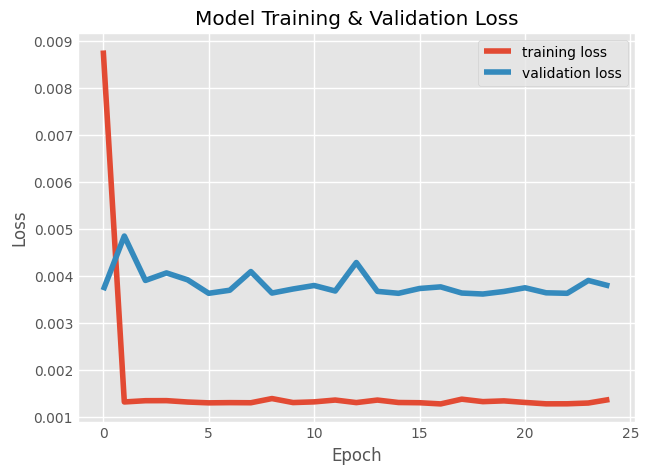

20/20 [==============================] - 0s 4ms/step


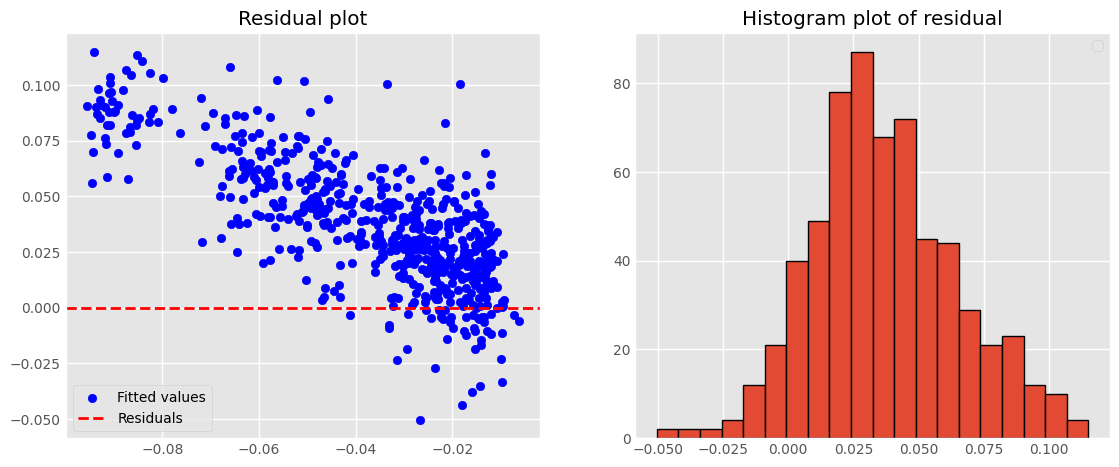

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d9dc35030> Loss    Validation <keras.src.losses.Huber object at 0x7a7d9dc35030> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00137049                                                           0.00378603        0.0523543       0.0377937          7.67064          0.0870176          0.055497          1.863e+06 




In [48]:
model_simple_rnn3 = Sequential()
model_simple_rnn3.add(SimpleRNN(50, activation='tanh',input_shape=(look_back, 1)))
model_simple_rnn3.add(Dense(1, activation='tanh'))

# Compile the model
model_simple_rnn3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
rnn3_stats, rnn3_predictions= train(model=model_simple_rnn3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# RNN with Dropout

## Mean Absolute Error (MAE)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 26ms/step - loss: 0.2194 - root_mean_squared_error: 0.2881 - mean_absolute_error: 0.2194 - mean_absolute_percentage_error: 43.2569 - val_loss: 0.1661 - val_root_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.166

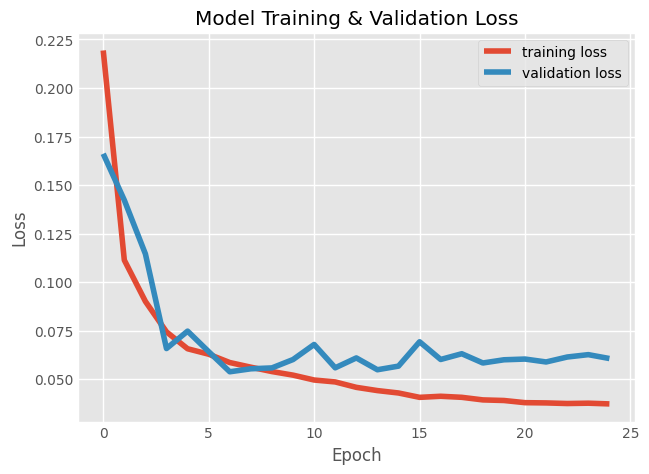

20/20 [==============================] - 0s 4ms/step


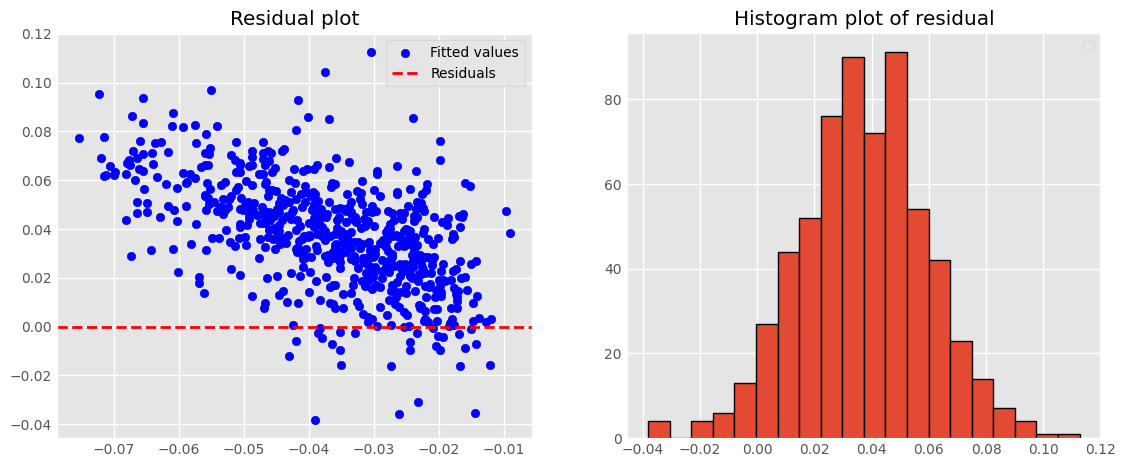

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0372045                               0.060592        0.0525018       0.0372045           7.5459          0.0930619          0.060592        1.95932e+06 




In [49]:
model_simple_rnn_with_dropout1 = Sequential()
model_simple_rnn_with_dropout1.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout1.add(Dropout(0.2))
model_simple_rnn_with_dropout1.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats1, rnn_with_dropout_predictions1 = train(model=model_simple_rnn_with_dropout1,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

## Mean Absolute Percentage Error

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 26ms/step - loss: 49.0184 - root_mean_squared_error: 0.3408 - mean_absolute_error: 0.2494 - mean_absolute_percentage_error: 49.0184 - val_loss: 1451727.3750 - val_root_mean_squared_error: 0.6995 - val_mean_absolute_error

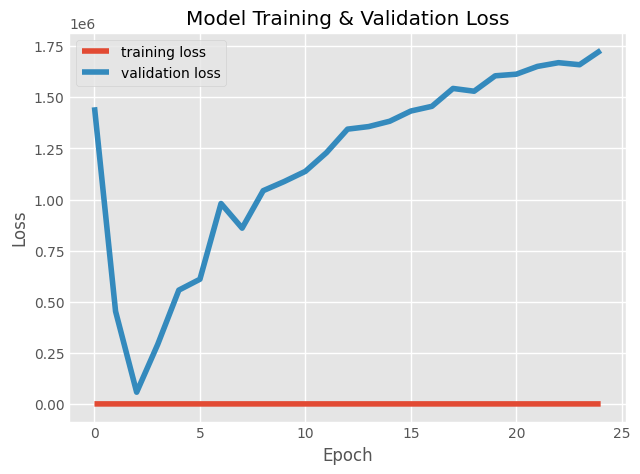

20/20 [==============================] - 0s 4ms/step


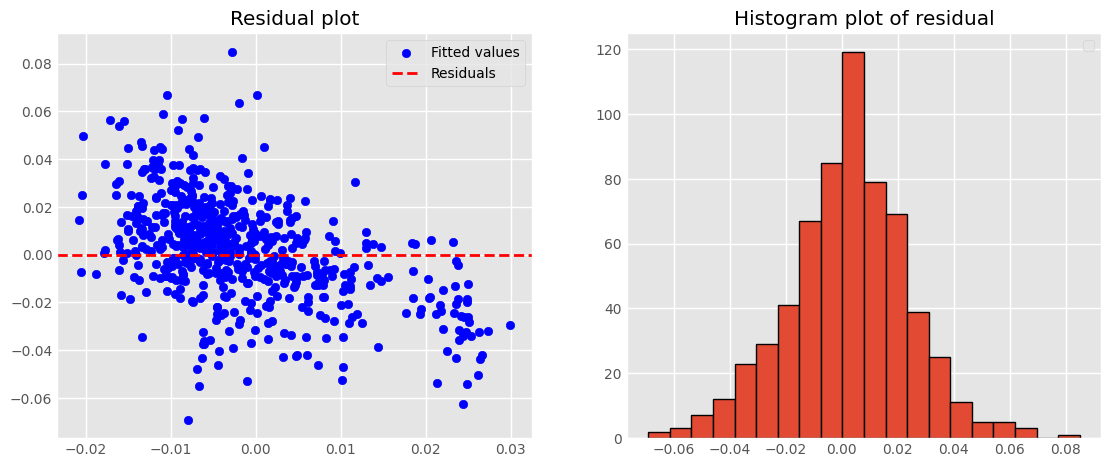

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.55085                                       1.72959e+06        0.0524082       0.0374992          7.55085          0.0852392         0.0539692        1.72959e+06 




In [50]:
model_simple_rnn_with_dropout2 = Sequential()
model_simple_rnn_with_dropout2.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout2.add(Dropout(0.2))
model_simple_rnn_with_dropout2.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats2, rnn_with_dropout_predictions2 = train(model=model_simple_rnn_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

## Huber

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 10)                120       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 5s 44ms/step - loss: 0.0650 - root_mean_squared_error: 0.3607 - mean_absolute_error: 0.2702 - mean_absolute_percentage_error: 53.0517 - val_loss: 0.0062 - val_root_mean_squared_error: 0.1110 - val_mean_absolute_error: 0.078

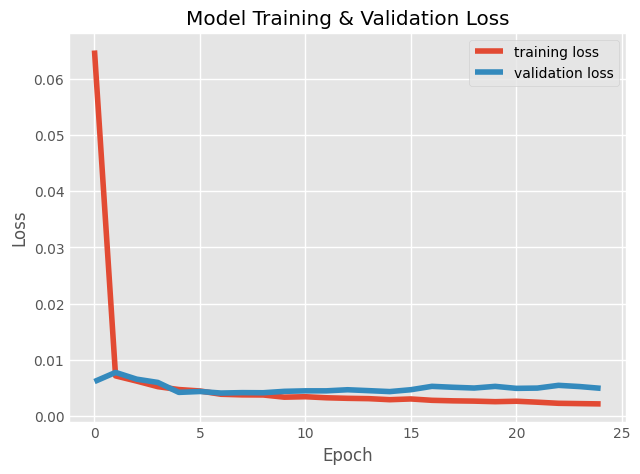

20/20 [==============================] - 0s 8ms/step


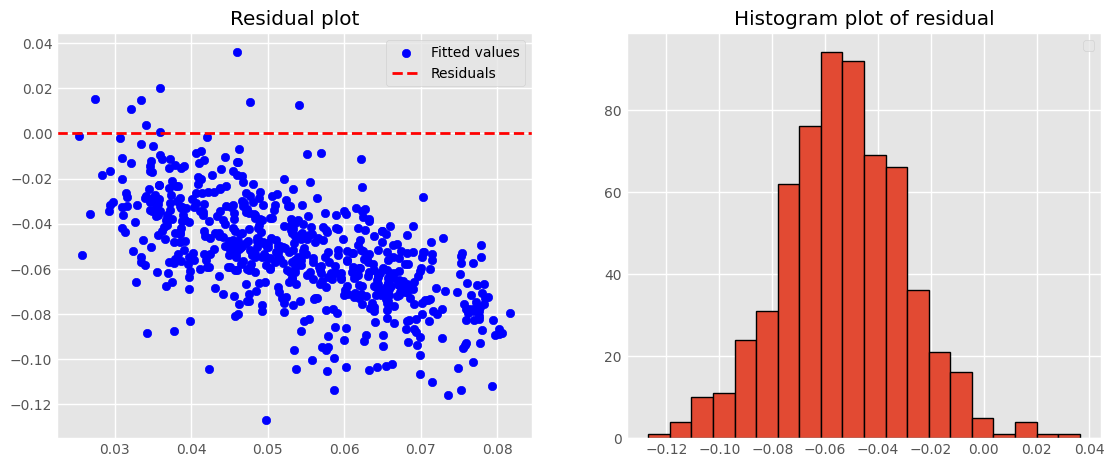

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d9d250a90> Loss    Validation <keras.src.losses.Huber object at 0x7a7d9d250a90> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00219111                                                           0.00496221        0.0661983       0.0504501          10.1261          0.0996214         0.0682344        2.13417e+06 




In [51]:
model_simple_rnn_with_dropout3 = Sequential()
model_simple_rnn_with_dropout3.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, 1)))
model_simple_rnn_with_dropout3.add(Dropout(0.2))
model_simple_rnn_with_dropout3.add(Dense(1, activation='tanh'))


model_simple_rnn_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
rnn_with_dropout_stats3, rnn_with_dropout_predictions3 = train(model=model_simple_rnn_with_dropout3,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

# LTSM

## Mean Absolute Error

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 13ms/step - loss: 0.1267 - root_mean_squared_error: 0.1889 - mean_absolute_error: 0.1267 - mean_absolute_percentage_error: 24.9153 - val_loss: 0.0535 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0535 - val_mean_absolute_percentage_error: 2019779.2500
Epoch 2/25
73/73 [==============================] - 1s 7ms/step - loss: 0.0357 - 

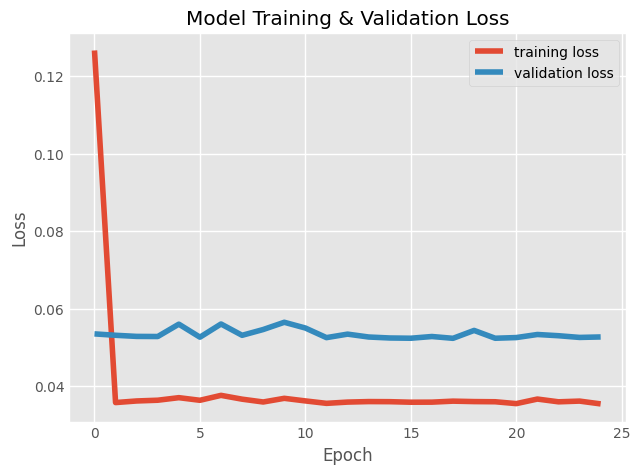

20/20 [==============================] - 0s 2ms/step


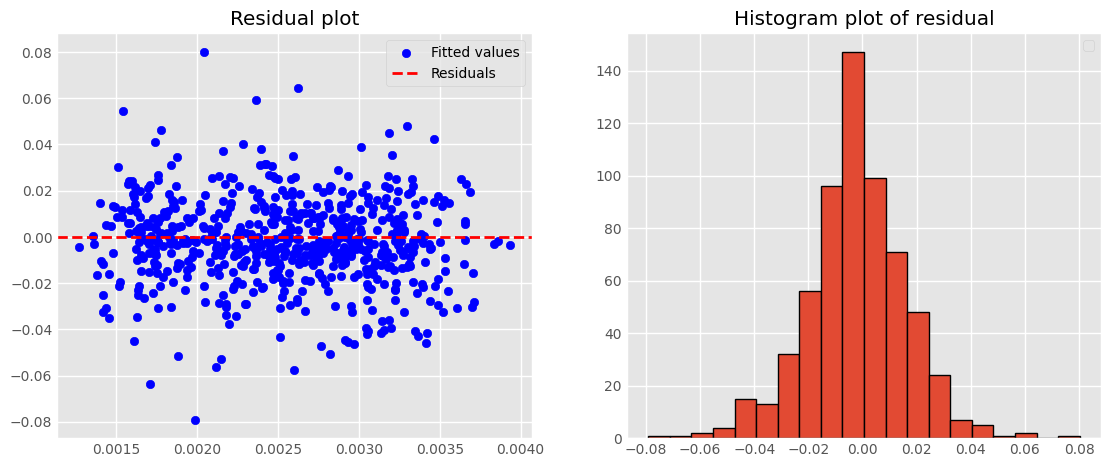

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0353777                              0.0526732        0.0503389       0.0353777          7.20117          0.0859051         0.0526732        1.97345e+06 




In [52]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_lstm1.add(Dense(1,activation='tanh'))

# Compile the model
model_lstm1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model

lstm1_stats, lstm1_predictions= train(model=model_lstm1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Mean Absolute Percentage Error

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 13ms/step - loss: 25.6039 - root_mean_squared_error: 0.1893 - mean_absolute_error: 0.1296 - mean_absolute_percentage_error: 25.6039 - val_loss: 1782958.6250 - val_root_mean_squared_error: 0.0963 - val_mean_absolute_error: 0.0672 - val_mean_absolute_percentage_error: 1782958.6250
Epoch 2/25
73/73 [==============================] - 1s 7ms/step - loss: 7.

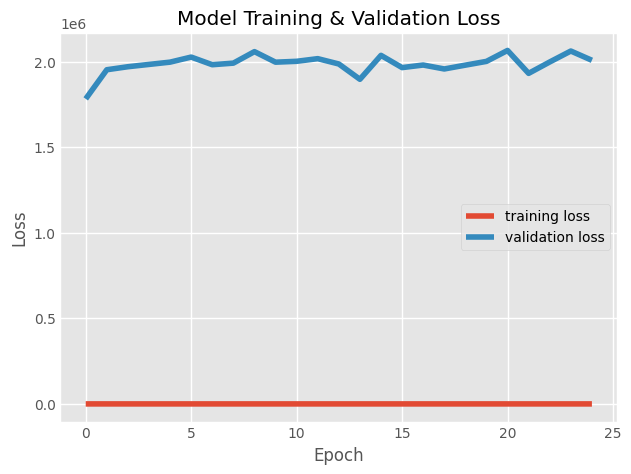

20/20 [==============================] - 0s 2ms/step


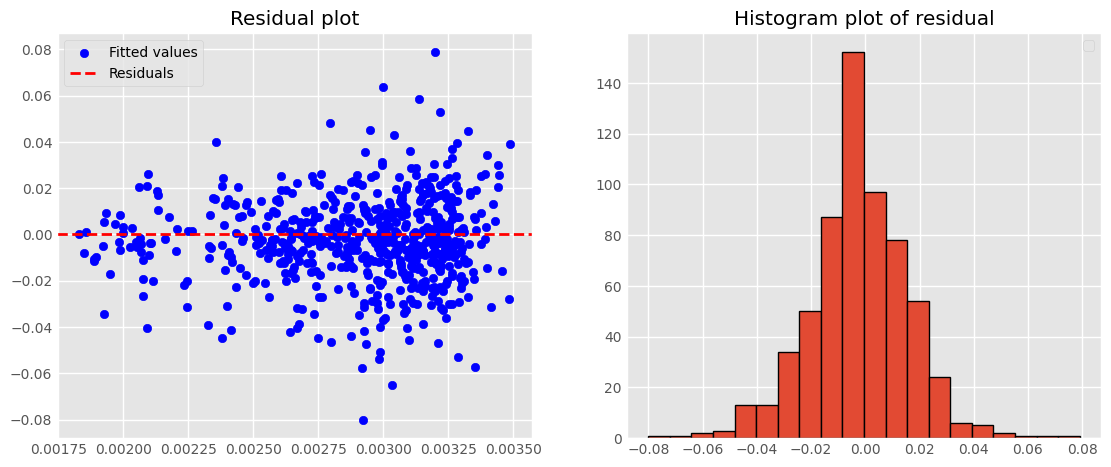

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.17757                                       2.00836e+06         0.050479       0.0355127          7.17757           0.085789         0.0525547        2.00836e+06 




In [53]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm2_stats, lstm2_predictions= train(model=model_lstm2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Huber

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 21ms/step - loss: 0.0232 - root_mean_squared_error: 0.2154 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 29.4248 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1435 - val_mean_absolute_error: 0.1238 - val_mean_absolute_percentage_error: 2491731.7500
Epoch 2/25
73/73 [==============================] - 1s 10ms/step - loss: 0.0014 -

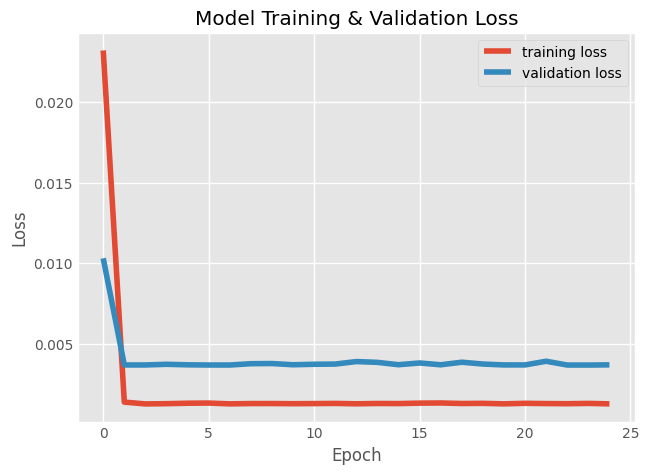

20/20 [==============================] - 1s 4ms/step


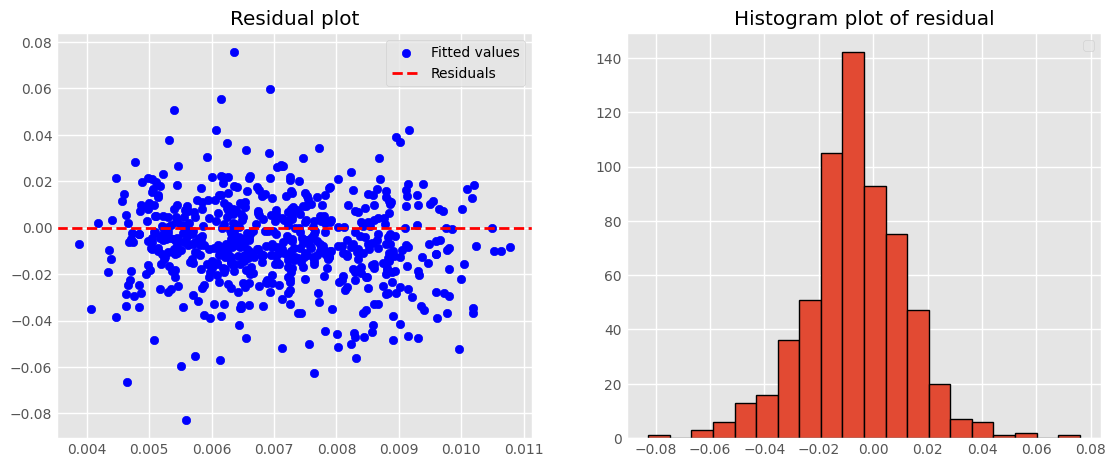

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d0c30dae0> Loss    Validation <keras.src.losses.Huber object at 0x7a7d0c30dae0> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00126809                                                           0.00368822        0.0503605       0.0355951          7.25152          0.0858862         0.0524834        2.03414e+06 




In [54]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_lstm3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
lstm3_stats, lstm3_predictions= train(model=model_lstm3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# LSTM with Dropout

## Mean Absolute Error

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 14ms/step - loss: 0.1419 - root_mean_squared_error: 0.2058 - mean_absolute_error: 0.1419 - mean_absolute_percentage_error: 27.9441 - val_loss: 0.0531 - val_root_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0531

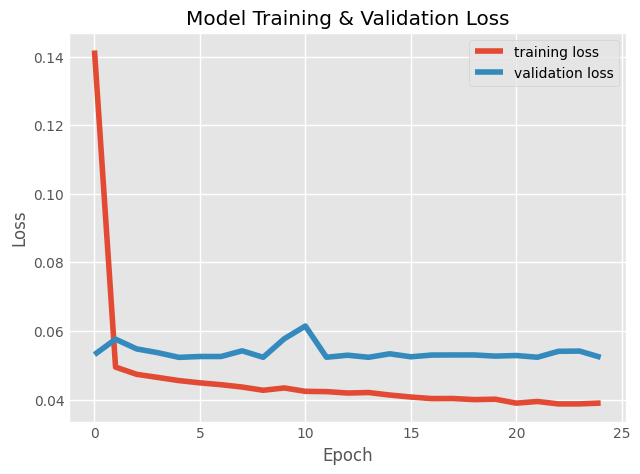

20/20 [==============================] - 1s 4ms/step


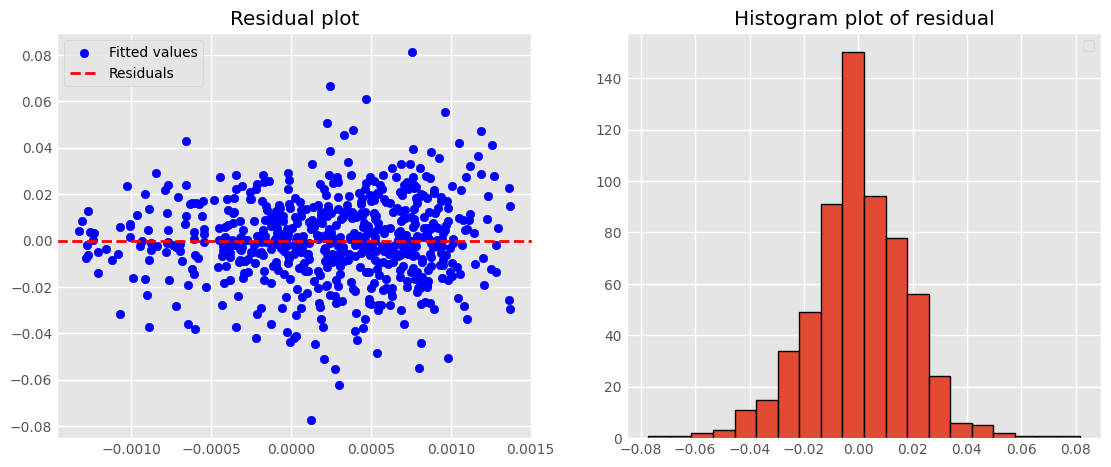

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0389794                              0.0523213        0.0534295       0.0389794          7.90928          0.0856754         0.0523213        1.98959e+06 




In [55]:
# Create the model
model_lstm_with_dropout1 = Sequential()
model_lstm_with_dropout1.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout1.add(Dropout(0.2))
model_lstm_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout1.compile(optimizer='adam',loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats1, lstm_with_dropout_predictions1 = train(model=model_lstm_with_dropout1,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


## Mean Absolute Percentage Error

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 14ms/step - loss: 26.1635 - root_mean_squared_error: 0.1871 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 26.1635 - val_loss: 2149331.5000 - val_root_mean_squared_error: 0.0947 - val_mean_absolute_error:

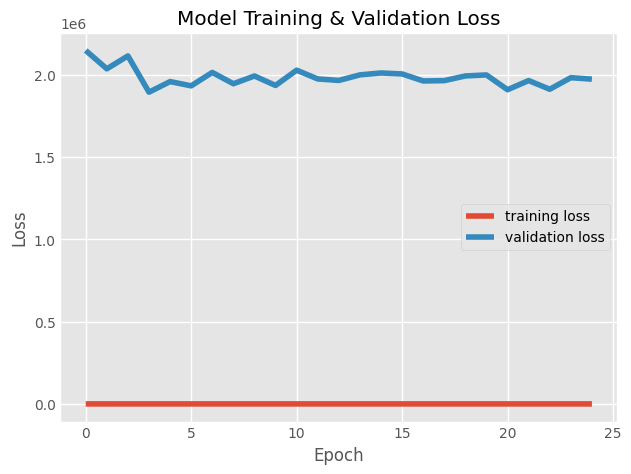

20/20 [==============================] - 0s 2ms/step


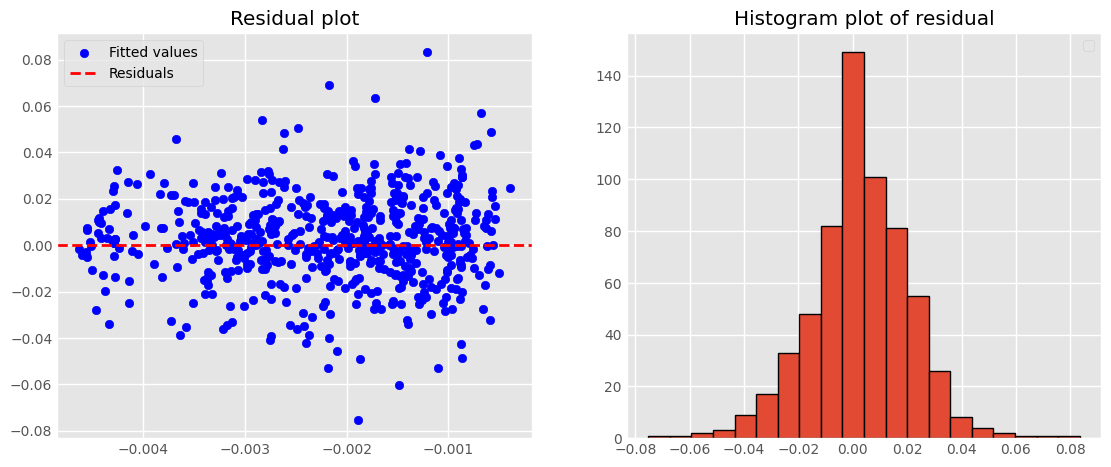

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.85339                                       1.97482e+06        0.0539322        0.038944          7.85339          0.0857701         0.0525872        1.97482e+06 




In [56]:
# Create the model
model_lstm_with_dropout2 = Sequential()
model_lstm_with_dropout2.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout2.add(Dropout(0.2))
model_lstm_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout2.compile(optimizer='adam',loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats2, lstm_with_dropout_predictions2 = train(model=model_lstm_with_dropout2,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)


## Huber

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 14ms/step - loss: 0.0214 - root_mean_squared_error: 0.2070 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 29.7513 - val_loss: 0.0072 - val_root_mean_squared_error: 0.1198 - val_mean_absolute_error: 0.0964

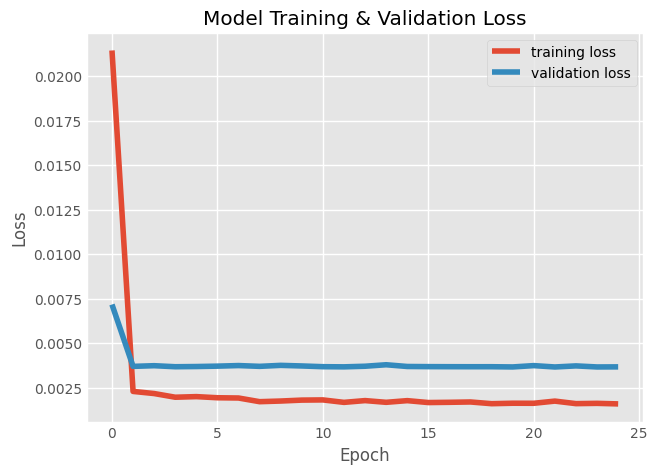

20/20 [==============================] - 1s 4ms/step


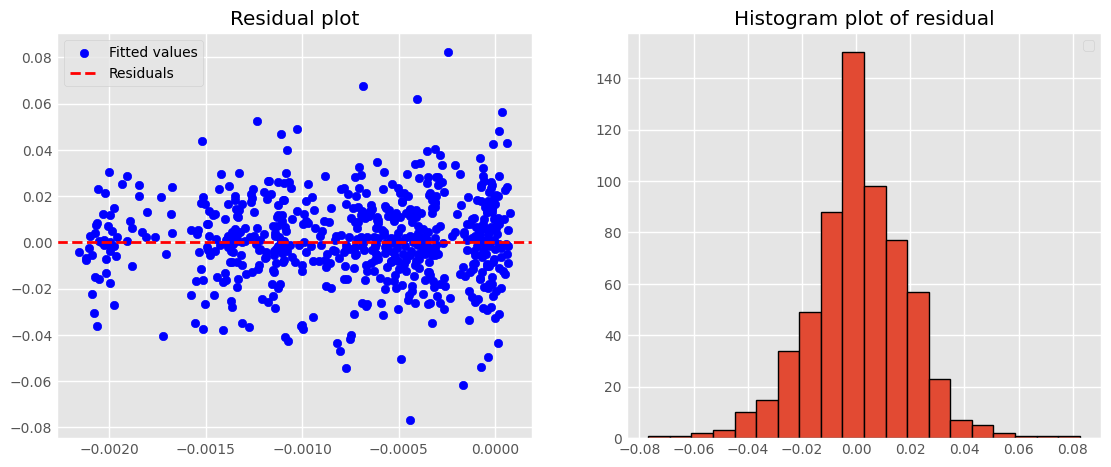

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d002e7c40> Loss    Validation <keras.src.losses.Huber object at 0x7a7d002e7c40> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                        0.0015989                                                           0.00367705        0.0565491       0.0417233          8.43994          0.0857561         0.0524731        1.97076e+06 




In [57]:
# Create the model
model_lstm_with_dropout3 = Sequential()
model_lstm_with_dropout3.add(LSTM(50, activation='tanh', input_shape=(look_back, 1)))
model_lstm_with_dropout3.add(Dropout(0.2))
model_lstm_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model
model_lstm_with_dropout3.compile(optimizer='adam',loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
lstm_with_dropout_stats3, lstm_with_dropout_predictions3 = train(model=model_lstm_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)

# GRU

## Mean Absolute Error

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 13ms/step - loss: 0.1315 - root_mean_squared_error: 0.1949 - mean_absolute_error: 0.1315 - mean_absolute_percentage_error: 25.9047 - val_loss: 0.0593 - val_root_mean_squared_error: 0.0910 - val_mean_absolute_error: 0.0593 - val_mean_absolute_percentage_error: 2110004.0000
Epoch 2/25
73/73 [==============================] - 0s 7ms/step - loss: 0.0364 - r

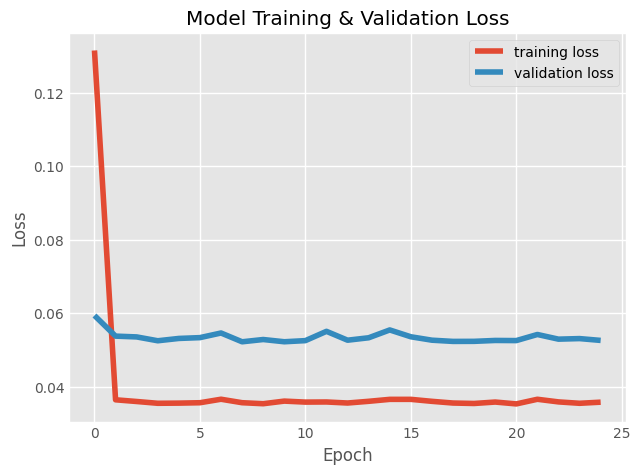

20/20 [==============================] - 0s 3ms/step


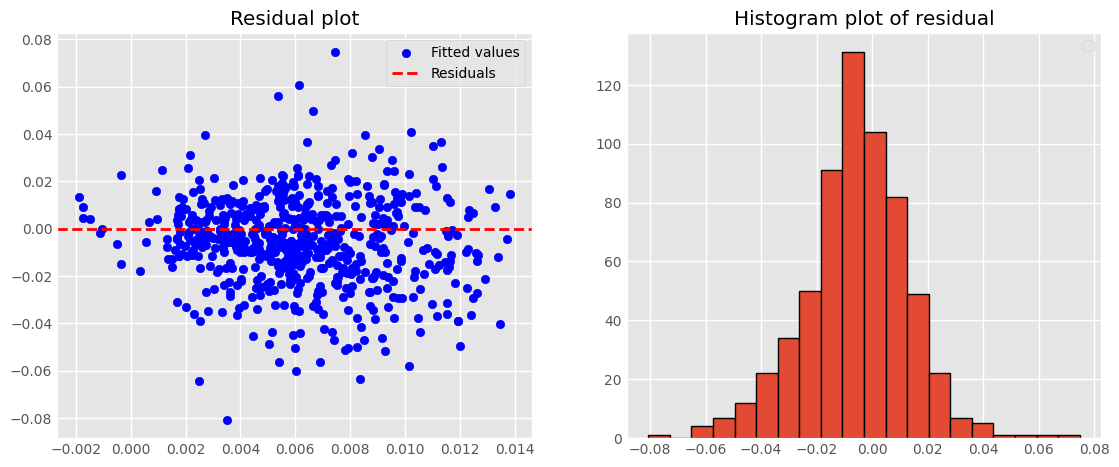

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0357405                              0.0525448        0.0507112       0.0357405          7.27304          0.0861453         0.0525448        2.09985e+06 




In [58]:
model_gru1 = Sequential()
model_gru1.add(GRU(50, activation='tanh',input_shape=(look_back, 1)))
model_gru1.add(Dense(1, activation='tanh'))

# Compile the model
model_gru1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru1_stats, gru1_predictions= train(model=model_gru1,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Mean Absolute Percentage Error

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                7950      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 13ms/step - loss: 24.5515 - root_mean_squared_error: 0.1823 - mean_absolute_error: 0.1246 - mean_absolute_percentage_error: 24.5515 - val_loss: 2144264.2500 - val_root_mean_squared_error: 0.0945 - val_mean_absolute_error: 0.0642 - val_mean_absolute_percentage_error: 2144264.2500
Epoch 2/25
73/73 [==============================] - 1s 7ms/step - loss: 7.2

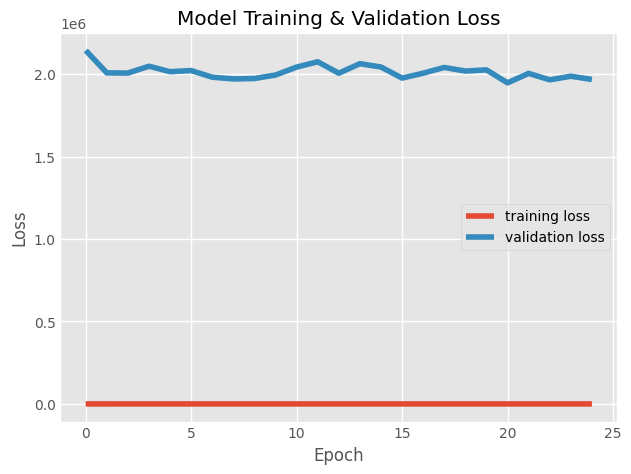

20/20 [==============================] - 0s 2ms/step


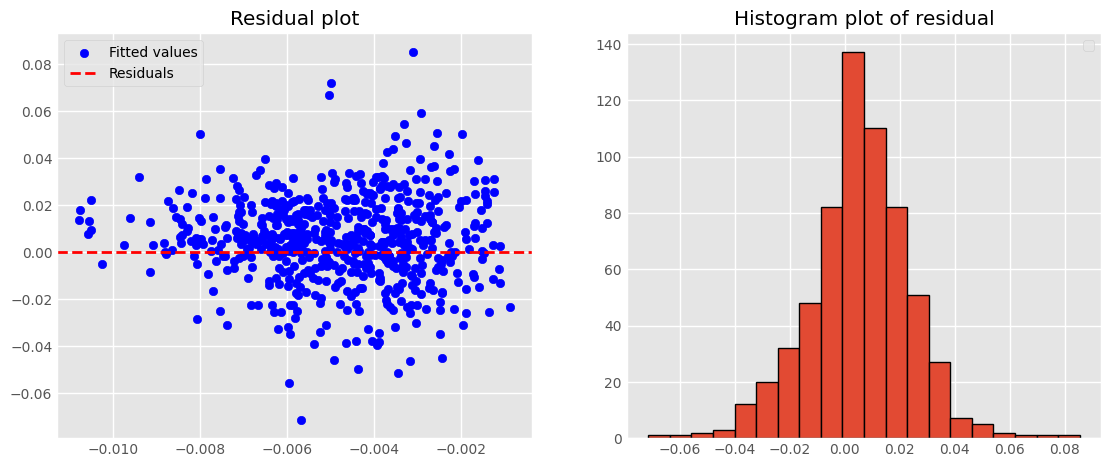

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.13985                                       1.96845e+06        0.0503756       0.0352796          7.13985          0.0870546         0.0549158        1.96845e+06 




In [59]:
model_gru2 = Sequential()
model_gru2.add(GRU(50, activation='tanh',input_shape=(look_back, 1)))
model_gru2.add(Dense(1, activation='tanh'))

# Compile the model
model_gru2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru2_stats, gru2_predictions= train(model=model_gru2,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

## Huber

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 20ms/step - loss: 0.0193 - root_mean_squared_error: 0.1964 - mean_absolute_error: 0.1387 - mean_absolute_percentage_error: 27.2642 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1437 - val_mean_absolute_error: 0.1248 - val_mean_absolute_percentage_error: 2455670.5000
Epoch 2/25
73/73 [==============================] - 1s 11ms/step - loss: 0.0014 

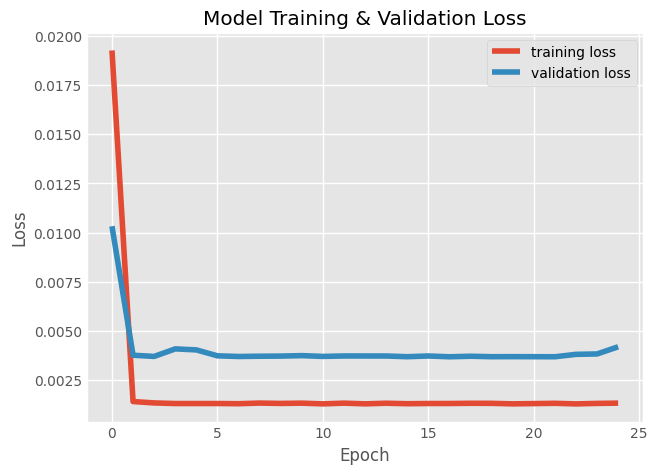

20/20 [==============================] - 1s 4ms/step


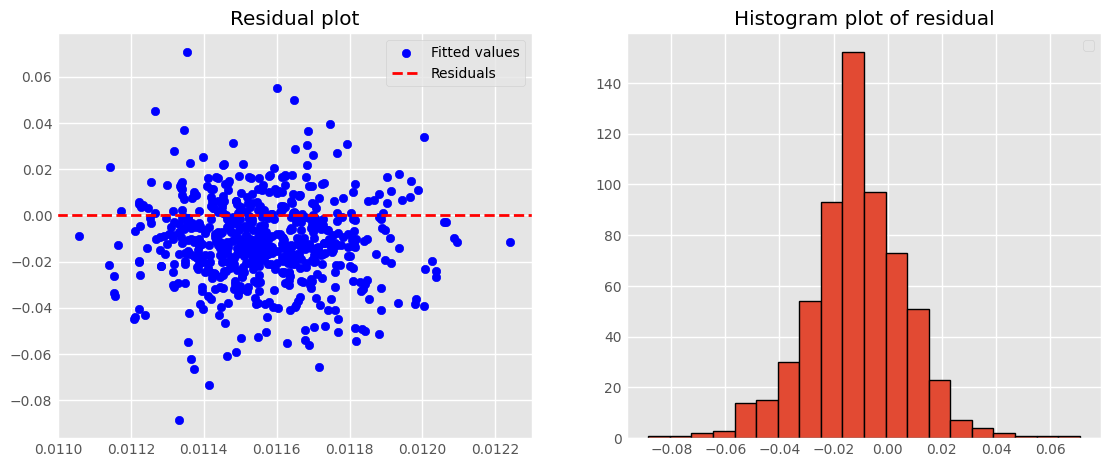

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d9dc35b70> Loss    Validation <keras.src.losses.Huber object at 0x7a7d9dc35b70> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00131126                                                           0.00418118        0.0512106       0.0364038          7.39847          0.0914459         0.0603267        2.11138e+06 




In [60]:
model_gru3 = Sequential()
model_gru3.add(LSTM(50, activation='tanh',input_shape=(look_back, 1)))
model_gru3.add(Dense(1, activation='tanh'))

# Compile the model
model_gru3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])

# Train the model
gru3_stats, gru3_predictions= train(model=model_gru3,
                                    X_train=X_train,
                                    y_train=y_train,
                                    X_test=X_test,
                                    y_test=y_test,
                                    epochs=25,
                                    batch_size=32,
                                    shuffle=True,
                                    validation_split = 0.1)

# GRU with Dropout

## Mean Absolute Error

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 4s 13ms/step - loss: 0.1517 - root_mean_squared_error: 0.2166 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 29.7882 - val_loss: 0.0664 - val_root_mean_squared_error: 0.0964 - val_mean_absolute_error: 0.0664 -

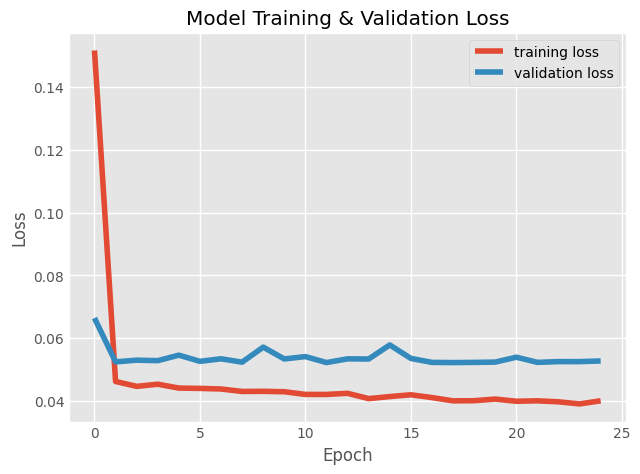

20/20 [==============================] - 0s 3ms/step


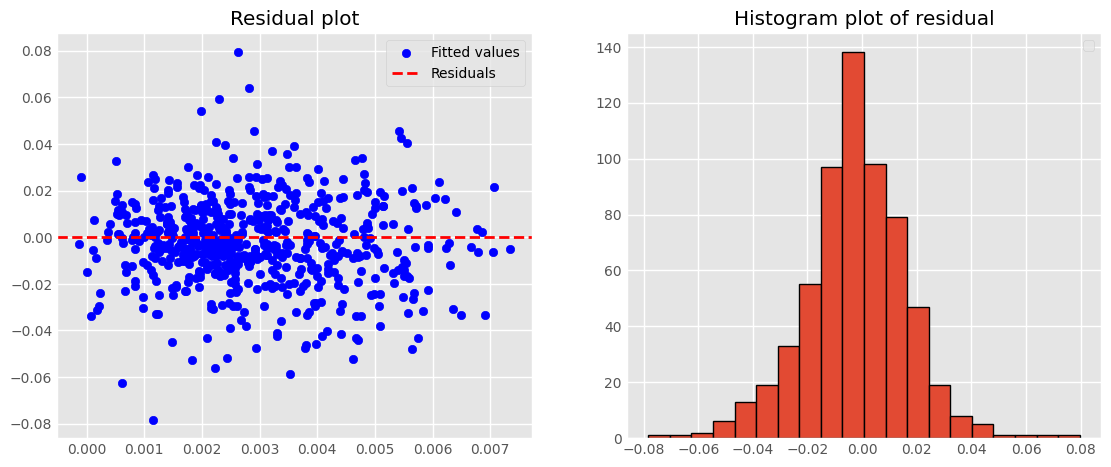

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_error Loss    Validation mean_absolute_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------  -------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                          0.0400667                              0.0527601        0.0547631       0.0400667          8.11292          0.0859361         0.0527601        1.99849e+06 




In [61]:
# Create the model with MAE loss and Dropout
model_gru_with_dropout1 = Sequential()
model_gru_with_dropout1.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout1.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout1.add(Dense(1, activation='tanh'))

# Compile the model with MAE loss
model_gru_with_dropout1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats1, gru_with_dropout_predictions1 = train(model=model_gru_with_dropout1,
                                                          X_train=X_train,
                                                          y_train=y_train,
                                                          X_test=X_test,
                                                          y_test=y_test,
                                                          epochs=25,
                                                          batch_size=32,
                                                          shuffle=True,
                                                          validation_split=0.1)


## Mean Absolute Percentage Error

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 16ms/step - loss: 30.0836 - root_mean_squared_error: 0.2199 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 30.0836 - val_loss: 2221480.7500 - val_root_mean_squared_error: 0.1023 - val_mean_absolute_error: 0

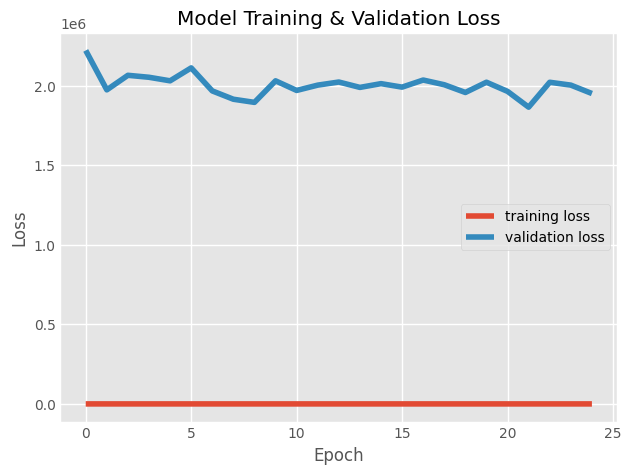

20/20 [==============================] - 0s 2ms/step


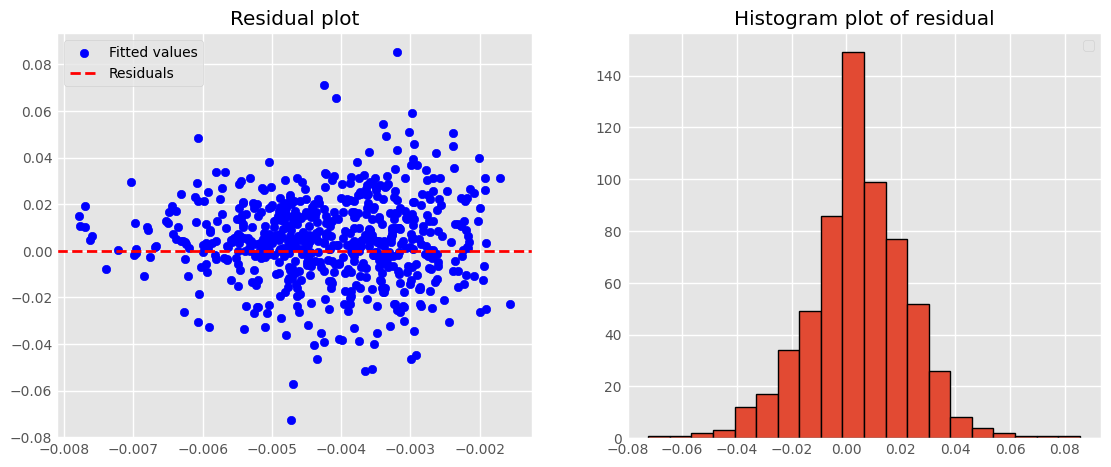

<Figure size 512x384 with 0 Axes>


   Training mean_absolute_percentage_error Loss    Validation mean_absolute_percentage_error Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
----------------------------------------------  ------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                       7.89747                                       1.95085e+06         0.054093       0.0392901          7.89747          0.0871536         0.0550693        1.95085e+06 




In [62]:
# Create the model with MAPE loss and Dropout
model_gru_with_dropout2 = Sequential()
model_gru_with_dropout2.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout2.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout2.add(Dense(1, activation='tanh'))

# Compile the model with MAPE loss
model_gru_with_dropout2.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats2, gru_with_dropout_predictions2 = train(model=model_gru_with_dropout2,
                                                            X_train=X_train,
                                                            y_train=y_train,
                                                            X_test=X_test,
                                                            y_test=y_test,
                                                            epochs=25,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            validation_split=0.1)

## Huber

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                7950      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
73/73 [==============================] - 3s 13ms/step - loss: 0.0224 - root_mean_squared_error: 0.2116 - mean_absolute_error: 0.1464 - mean_absolute_percentage_error: 28.7757 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1521 - val_mean_absolute_error: 0.1334 -

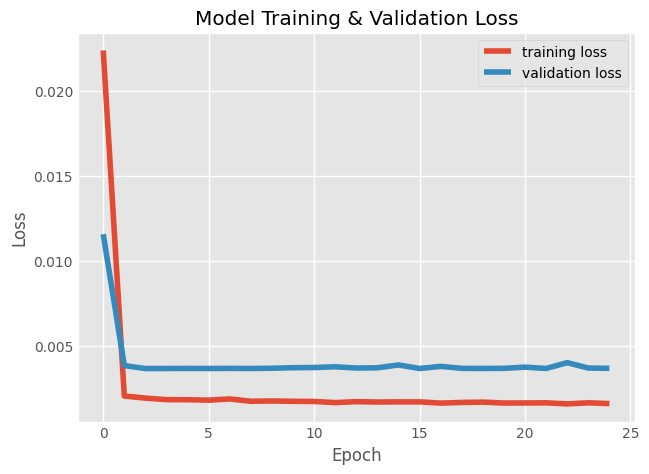

20/20 [==============================] - 0s 3ms/step


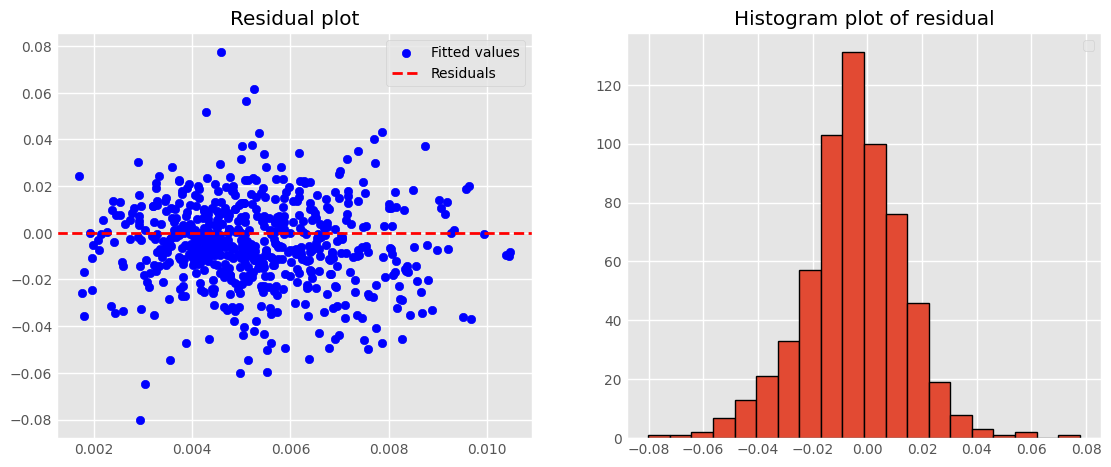

<Figure size 512x384 with 0 Axes>


   Training <keras.src.losses.Huber object at 0x7a7d9cfaaa10> Loss    Validation <keras.src.losses.Huber object at 0x7a7d9cfaaa10> Loss    Training RMSE    Training MAE    Training MAPE    Validation RMSE    Validation MAE    Validation MAPE
-----------------------------------------------------------------  -------------------------------------------------------------------  ---------------  --------------  ---------------  -----------------  ----------------  -----------------
                                                       0.00159975                                                           0.00367365        0.0565641       0.0417989          8.44589          0.0857164         0.0522075        2.03757e+06 




In [63]:
# Create the model with Huber loss and Dropout
model_gru_with_dropout3 = Sequential()
model_gru_with_dropout3.add(GRU(50, activation='tanh', input_shape=(look_back, 1)))
model_gru_with_dropout3.add(Dropout(0.2))  # Add Dropout layer
model_gru_with_dropout3.add(Dense(1, activation='tanh'))

# Compile the model with Huber loss
model_gru_with_dropout3.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])

# Train the model
gru_with_dropout_stats3, gru_with_dropout_predictions3 = train(model=model_gru_with_dropout3,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              X_test=X_test,
                                                              y_test=y_test,
                                                              epochs=25,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              validation_split=0.1)
